In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

In [3]:
annotations_shapefile = "data/shapefile/grid/swiss_tree_annotations_with_filtered_grid.shp"
anno_df = gpd.read_file(annotations_shapefile)

split_csv = "data/grid_split_result.csv"
grid_split = pd.read_csv(split_csv)

anno_centroids = anno_df.copy()
anno_centroids["geometry"] = anno_centroids.geometry.centroid
anno_df['grid_id'] = anno_df['grid_id'].astype(int)

In [4]:
anno_with_split = anno_df.merge(grid_split, on="grid_id", how="left")

split_counts = anno_with_split["split"].value_counts()

print("🌳 Total samples per split:")
print(split_counts)

🌳 Total samples per split:
split
train         17089
validation     3660
test           3659
Name: count, dtype: int64


In [6]:
species_split_counts = (
    anno_with_split.groupby(["split", "TreeAI_ID"])
    .size()
    .unstack(fill_value=0)
)

REMOVE_SPECIES = [49, 62, 64]
species_split_counts = species_split_counts.drop(columns=REMOVE_SPECIES, errors='ignore')

print("Number of samples per species in each split (after removal):")
print(species_split_counts)

Number of samples per species in each split (after removal):
TreeAI_ID     3    6    9     12    13    24   26  30  36   43   56   63
split                                                                   
test         415  123  124   235  2111   265   72   5   7  139  119   44
train       1940  574  579  1094  9854  1237  334  27  42  646  555  206
validation   416  123  124   234  2112   265   71   5   7  138  119   44


In [7]:
species_split_counts.to_csv("data/split_species_counts_filtered.csv")

In [12]:
species_split_counts = species_split_counts[
    species_split_counts.loc["train"].sort_values(ascending=False).index
]

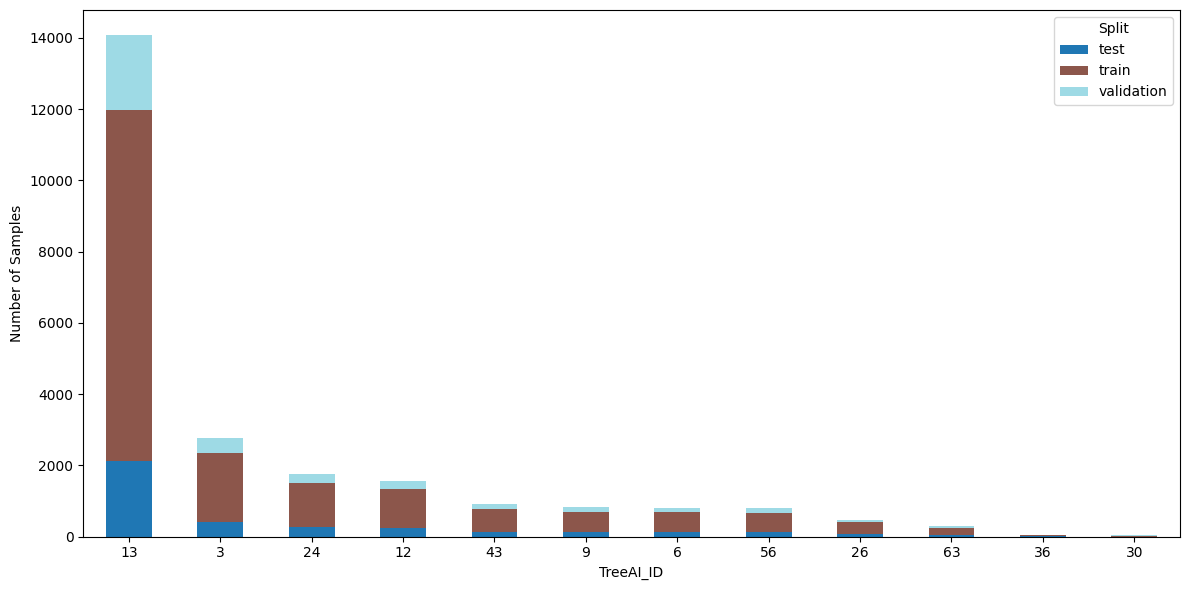

In [16]:
species_split_counts.T.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='tab20'
)

plt.xlabel("TreeAI_ID")
plt.ylabel("Number of Samples")
plt.legend(title="Split")
plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()

In [8]:
import os
import cv2
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import numpy as np
import rasterio
from matplotlib import pyplot as plt
from matplotlib import cm

In [10]:
root_path = f"data/TreeAI_Swiss/images_png"
images = list(Path(root_path).glob("*.png"))
for image in tqdm(images):
    image_id = image.name[:4]
    dem_path = str(image).replace("images_png", "DEM").replace(".png", ".tif")
    dsm_path = str(image).replace("images_png", "DSM").replace(".png", ".tif")
    with rasterio.open(dem_path) as dem_src, rasterio.open(dsm_path) as dsm_src:
        dem = dem_src.read().squeeze()
        dsm = dsm_src.read().squeeze()
    vhm = dsm - dem

    vhm = (vhm - vhm.min()) / (vhm.max() - vhm.min() + 1e-6)
    vhm_uint8 = (vhm * 255).astype(np.uint8)
    cmap = cm.get_cmap('viridis')
    colored_vhm = cmap(vhm)[:, :, :3]
    colored_vhm = (colored_vhm * 255).astype(np.uint8)

    save_path = os.path.join("data/TreeAI_Swiss/VHM_color", f"{image_id}.png")
    cv2.imwrite(save_path, cv2.cvtColor(colored_vhm, cv2.COLOR_RGB2BGR))

  0%|          | 0/7291 [00:00<?, ?it/s]/var/folders/pb/3klkrw2n4fzggxq272xxq_pm0000gn/T/ipykernel_1279/872915727.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
100%|██████████| 7291/7291 [00:23<00:00, 313.92it/s]


In [ ]:
root_path = f"data/TreeAI_Swiss/images_png"
images = list(Path(root_path).glob("*.png"))
for image in tqdm(images):
    image_id = image.name[:4]
    dem_path = str(image).replace("images_png", "DEM").replace(".png", ".tif")
    dsm_path = str(image).replace("images_png", "DSM").replace(".png", ".tif")
    with rasterio.open(dem_path) as dem_src, rasterio.open(dsm_path) as dsm_src:
        dem = dem_src.read().squeeze()
        dsm = dsm_src.read().squeeze()
    vhm = dsm - dem

    vhm = cv2.resize(vhm, (600, 600), interpolation=cv2.INTER_LINEAR)
    vhm_mask = vhm < 5.0
    mask_3c = np.repeat(vhm_mask[:, :, None], 3, axis=2)

    image_array = np.array(Image.open(image).convert("RGB"))
    rgb_masked = image_array.copy()
    rgb_masked[mask_3c] = 0

    save_path = os.path.join("data/TreeAI_Swiss/images_masked", f"{image_id}.png")
    cv2.imwrite(save_path, cv2.cvtColor(rgb_masked, cv2.COLOR_RGB2BGR))

100%|██████████| 7291/7291 [01:56<00:00, 62.32it/s]


In [3]:
image = np.array(Image.open(rgb_path).convert("RGB"))
with rasterio.open(dem_path) as dem_src, rasterio.open(dsm_path) as dsm_src:
    dem = dem_src.read().squeeze()
    dsm = dsm_src.read().squeeze()
vhm = dsm - dem
image.shape, dem.shape, dsm.shape, vhm.shape

((600, 600, 3), (120, 120), (120, 120), (120, 120))

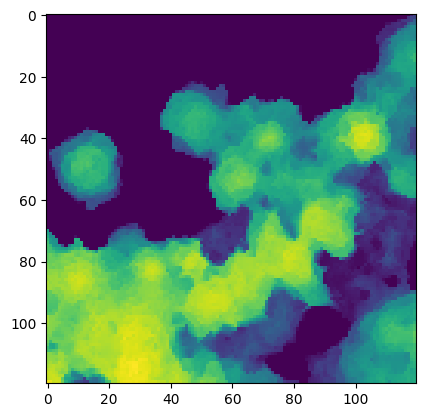

In [4]:
plt.imshow(vhm)

In [5]:
vhm = cv2.resize(vhm, (600, 600), interpolation=cv2.INTER_LINEAR)
vhm_mask = vhm < 5.0
mask_3c = np.repeat(vhm_mask[:, :, None], 3, axis=2)
rgb_masked = image.copy()
rgb_masked[mask_3c] = 0

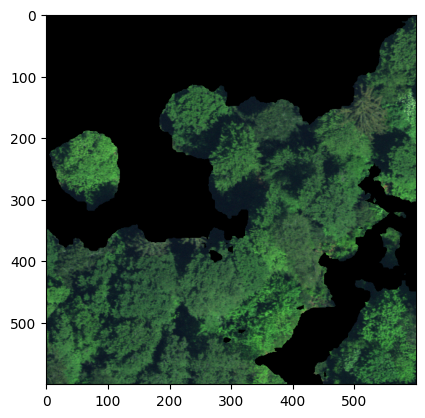

In [6]:
plt.imshow(rgb_masked)

In [ ]:
shade = 1 + 0.6 * (vhm_norm - 0.5)

rgb_enh = rgb * shade[:, :, None]
rgb_enh = np.clip(rgb_enh, 0, 1)

rgb_enh[vhm_mask[...,None].repeat(3,axis=2)] = 0

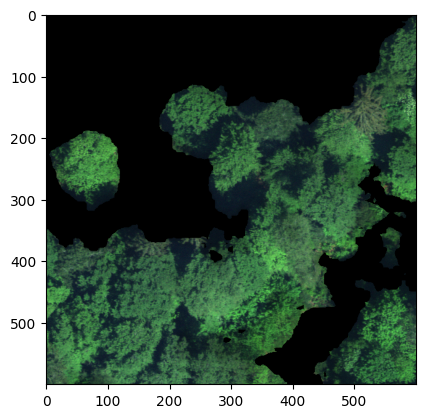

In [41]:
plt.imshow(rgb_enh)

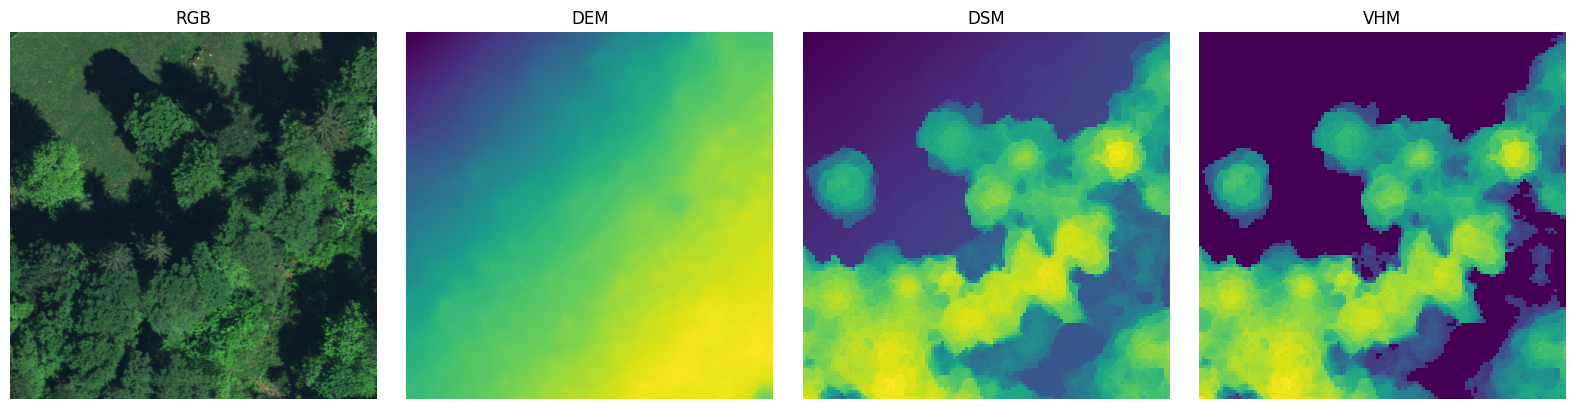

In [101]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("RGB")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(dem)
plt.title("DEM")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(dsm)
plt.title("DSM")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(vhm)

plt.title("VHM")
plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
import torch
from Utils.utils import get_divice

device = get_divice()
model = torch.hub.load('gastruc/anysat', 'anysat', pretrained=True, flash_attn=False)
model = model.to(device)

Using cache found in /Users/yixinzhou/.cache/torch/hub/gastruc_anysat_main


In [35]:
import datetime

def timestamp2doy(timestamps_len, batch_size, device, year=2023):
    
    if timestamps_len == 12:
        doys = []
        for m in range(1, 13):
            d = datetime.date(year, m, 15)
            doys.append(d.timetuple().tm_yday)

    elif timestamps_len == 4:
        quarter_mid_months = [2, 5, 8, 11]
        doys = []
        for m in quarter_mid_months:
            d = datetime.date(year, m, 15)
            doys.append(d.timetuple().tm_yday)

    elif timestamps_len == 1:
        mid_date = datetime.date(year, 7, 2)
        doys = [mid_date.timetuple().tm_yday]
    else:
        doys = np.linspace(1, 365, timestamps_len).tolist()

    doys = torch.tensor(doys, dtype=torch.float32, device=device)

    doys = doys.unsqueeze(0).repeat(batch_size, 1)

    return doys


In [50]:
s1_dates = timestamp2doy(4, 4, device)
s2_dates = timestamp2doy(4, 4, device)

In [51]:
B = 4   # batch size

# Sentinel-2: [B, 12, 10, 6, 6]
s2_images = torch.randn(B, 4, 10, 6, 6).float()

# Sentinel-1: [B, 12, 3, 6, 6]
s1_images = torch.randn(B, 4, 3, 6, 6).float()

# Aerial RGB: [B, 3, 600, 600]  (or B,3,H,W)
aerial_images = torch.randn(B, 4, 300, 300).float()

In [52]:
data = {
    "aerial": aerial_images.to(device), #1 batch size, 4 channels, 300x300 pixels
    "s2": s2_images.to(device), #1 batch size, 146 dates, 10 channels, 6x6 pixels
    "s2_dates": s2_dates.to(device),
    "s1": s1_images.to(device), #1 batch size, 60 dates, 10 channels, 6x6 pixels
    "s1_dates": s1_dates.to(device),
}

In [53]:
features = model(data, patch_size=10, output='dense', output_modality="aerial") 
print(features.shape)

torch.Size([4, 30, 30, 1536])


In [13]:
import os
import h5py
import numpy as np
import random

def inspect_data_range_ignore_nan(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.hdf5')]
    
    if not files:
        print("错误：文件夹中没有找到 .h5 文件。")
        return

    # 随机选取一个文件
    filename = random.choice(files)
    file_path = os.path.join(folder_path, filename)
    
    print(f"正在检查文件: {filename}")
    print("-" * 50)

    try:
        with h5py.File(file_path, 'r') as f:
            keys_to_check = ['uav_image', 'sentinel1_ts', 'sentinel2_ts', 'bbox']
            
            for key in keys_to_check:
                if key in f:
                    data = f[key][:]
                    
                    # 检查是否全部都是 NaN，防止报错
                    if np.isnan(data).all():
                        print(f"[{key}]")
                        print(f"  Shape: {data.shape}")
                        print("  警告: 所有数据均为 NaN")
                        print("-" * 30)
                        continue

                    # --- 修改处：使用 nan-safe 函数忽略 NaN ---
                    d_min = np.nanmin(data)
                    d_max = np.nanmax(data)
                    d_mean = np.nanmean(data)
                    d_std = np.nanstd(data)
                    
                    d_type = data.dtype
                    d_shape = data.shape
                    
                    # 计算 NaN 的数量和比例
                    nan_count = np.isnan(data).sum()
                    nan_ratio = nan_count / data.size * 100
                    
                    print(f"[{key}]")
                    print(f"  Shape: {d_shape}")
                    print(f"  Type : {d_type}")
                    print(f"  Min  : {d_min:.4f}")
                    print(f"  Max  : {d_max:.4f}")
                    print(f"  Mean : {d_mean:.4f}")
                    if nan_count > 0:
                        print(f"  Info : 包含 {nan_count} 个 NaN ({nan_ratio:.2f}%) (已忽略)")
                    else:
                        print(f"  Info : 不包含 NaN")
                    print("-" * 30)
                else:
                    print(f"[{key}] 不存在于此文件中。")

    except Exception as e:
        print(f"读取文件出错: {e}")

if __name__ == "__main__":
    # --- 请在这里修改你的数据文件夹路径 ---
    target_folder = "data/TreeAI_Swiss_60/splits/train" 
    
    inspect_data_range_ignore_nan(target_folder)

正在检查文件: 1924.hdf5
--------------------------------------------------
[uav_image]
  Shape: (4, 600, 600)
  Type : uint16
  Min  : 223.0000
  Max  : 6327.0000
  Mean : 1110.2407
  Info : 不包含 NaN
------------------------------
[sentinel1_ts]
  Shape: (12, 2, 6, 6)
  Type : float32
  Min  : -16.6771
  Max  : -4.0546
  Mean : -10.2134
  Info : 不包含 NaN
------------------------------
[sentinel2_ts]
  Shape: (12, 10, 6, 6)
  Type : float32
  Min  : 0.0036
  Max  : 0.4278
  Mean : 0.1191
  Info : 包含 450 个 NaN (10.42%) (已忽略)
------------------------------
[bbox] 不存在于此文件中。
